In [1]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ", subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image

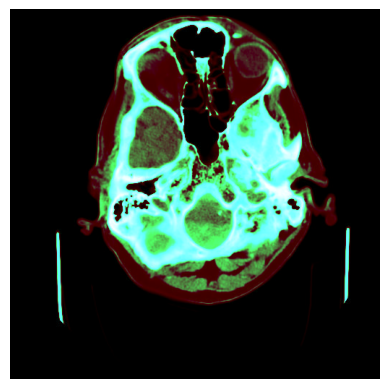

(512, 512, 3)

In [3]:
# Example usage
brain_bone_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_bone_window/ID_0a1a010bf.jpg"
brain_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_window/ID_0a1a010bf.jpg"
subdural_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/subdural_window/ID_0a1a010bf.jpg"

rgb_image = load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path)

plt.imshow(rgb_image)
plt.axis("off")
plt.show()

rgb_image.shape

In [4]:
def find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))
    mask_images = set(os.listdir(mask_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images).intersection(mask_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path, mask_path))

    return matching_image_paths


In [5]:
def build_unet(input_shape):
    """
    Simplified U-Net model for brain hemorrhage segmentation.
    Reduced complexity for faster training.
    """
    # inputs = keras.Input(shape=input_shape)
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder - fewer filters, one less level
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)  # 256x256

    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)  # 128x128

    # Bridge - fewer filters
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)

    # Decoder - fewer filters, one less level
    u4 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c3))  # 256x256
    u4 = tf.keras.layers.concatenate([u4, c2])
    c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)

    u5 = Conv2D(8, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))  # 512x512
    u5 = tf.keras.layers.concatenate([u5, c1])
    c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
bone_folder = 'Hemorrhage3000/brain_bone_window'
brain_folder = 'Hemorrhage3000/brain_window'
subdural_folder = 'Hemorrhage3000/subdural_window'

mask_folder = 'Hemorrhage3000/MasksData/bi-masks'
# mask_folder = 'Hemorrhage3000/MasksData/qu-masks'

matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder)

# Print the matching paths
print(len(matching_paths))

2901


In [7]:
normal_bone_folder = 'Normal3000/brain_bone_window_normal'
normal_brain_folder = 'Normal3000/brain_window_normal'
normal_subdural_folder = 'Normal3000/subdural_window_normal'

normal_mask_folder = 'Normal3000/MasksData/Mask_bi_normal'
# normal_mask_folder = 'Normal3000/MasksData/Mask_qu_normal'

normal_matching_paths = find_matching_image_paths(normal_bone_folder, normal_brain_folder, normal_subdural_folder, normal_mask_folder)

# Print the matching paths
print(len(normal_matching_paths))

3000


In [8]:
all_matching_paths = matching_paths + normal_matching_paths
print(len(all_matching_paths))

5901


In [9]:
# np.random.shuffle(all_matching_paths)

In [10]:
brain_img = []
mask_img = []

for paths in all_matching_paths:
    rgb_image = load_and_stack_as_rgb(paths[0], paths[1], paths[2])
    mask_image = cv2.imread(paths[3], cv2.IMREAD_GRAYSCALE)
    mask_image = mask_image / 255.0

    if (mask_image.shape == (512, 512)) & (rgb_image.shape == (512, 512, 3)):
        brain_img.append(np.array(rgb_image))
        mask_img.append(np.array(mask_image))


brain_bone.shape =  (462, 462) 	brain.shape =  (462, 462) 	subdural.shape =  (462, 462)
Path =  Hemorrhage3000/brain_bone_window\ID_c6463f07d.jpg

brain_bone.shape =  (638, 490) 	brain.shape =  (638, 490) 	subdural.shape =  (638, 490)
Path =  Hemorrhage3000/brain_bone_window\ID_88b0d8b4f.jpg

brain_bone.shape =  (464, 464) 	brain.shape =  (464, 464) 	subdural.shape =  (464, 464)
Path =  Normal3000/brain_bone_window_normal\ID_0144e4030.jpg


In [11]:
print(len(brain_img))
print(brain_img[0].shape)

print(len(mask_img))
print(mask_img[0].shape)

5898
(512, 512, 3)
5898
(512, 512)


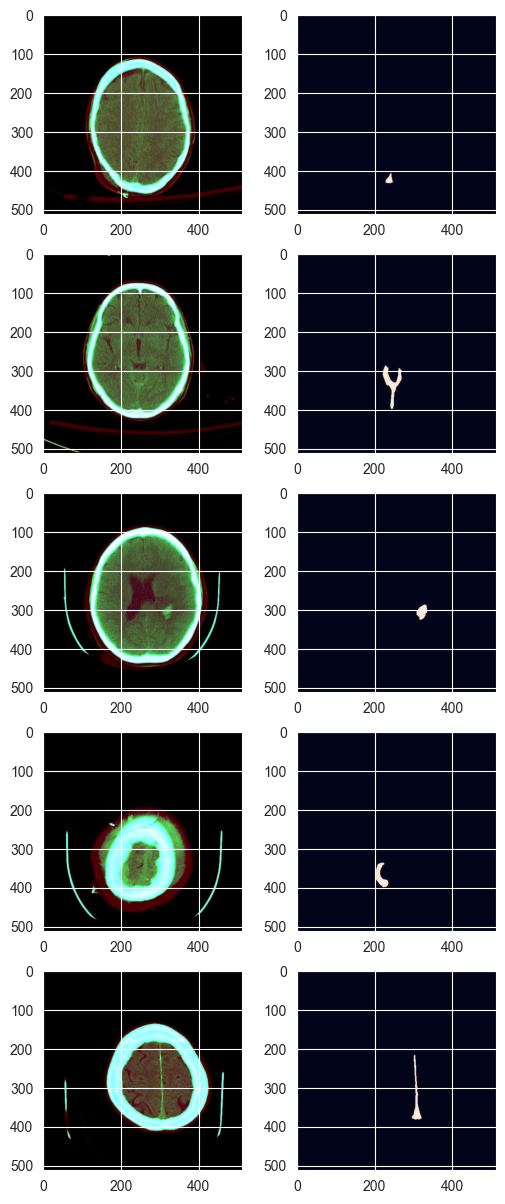

In [12]:
num_to_disp = 5

plt.figure(figsize=(6, 3*num_to_disp))
for index in range(num_to_disp):
    plt.subplot(num_to_disp, 2, index*2+1)
    plt.imshow(brain_img[index])
    plt.axis("on")

    plt.subplot(num_to_disp, 2, index*2+2)
    plt.imshow(mask_img[index])
    plt.axis("on")

plt.show()

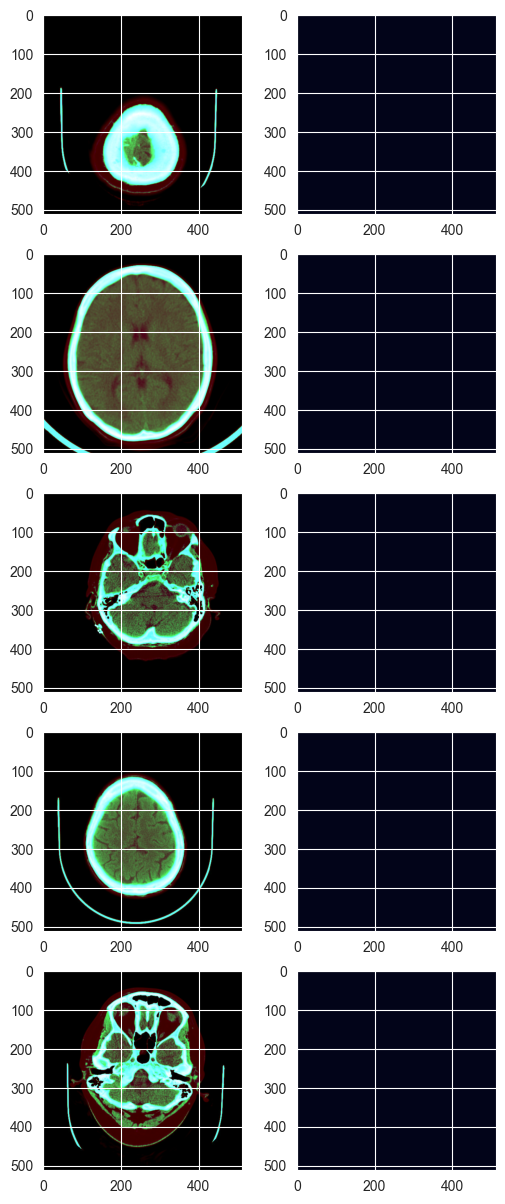

In [13]:
num_to_disp = 5
offset = 4000

plt.figure(figsize=(6, 3*num_to_disp))
for index in range(num_to_disp):
    plt.subplot(num_to_disp, 2, index*2+1)
    plt.imshow(brain_img[index+offset])
    plt.axis("on")

    plt.subplot(num_to_disp, 2, index*2+2)
    plt.imshow(mask_img[index+offset])
    plt.axis("on")

plt.show()

In [14]:
# Create a dataset from indices instead of the actual images
train_percentage = 0.8
validate_percentage = 0.1
test_percentage = 0.1

indices_dataset = tf.data.Dataset.from_tensor_slices(np.arange(len(brain_img)))
indices_dataset = indices_dataset.shuffle(buffer_size=len(brain_img))

# Function to load a single image pair by index
def load_image_mask_pair(idx):
    brain = tf.convert_to_tensor(brain_img[idx.numpy()], dtype=tf.float32)
    mask = tf.convert_to_tensor(mask_img[idx.numpy()], dtype=tf.float32)
    return brain, mask

# Modify your dataset mapping function
def tf_load_pair(idx):
    brain, mask = tf.py_function(
        load_image_mask_pair, [idx], [tf.float32, tf.float32]
    )
    brain.set_shape([512, 512, 3])
    mask.set_shape([512, 512])
    # Expand dimensions to add channel dimension for the mask
    mask = tf.expand_dims(mask, axis=-1)
    return brain, mask

# Apply the loading function to create the final dataset
dataset = indices_dataset.map(tf_load_pair)

# Split into train, validation, and test
train_size = int(train_percentage * len(brain_img))
val_size = int(validate_percentage * len(brain_img))

train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Batch the datasets
BATCH_SIZE = 2  # Try smaller batch size if memory is still an issue
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Images shape: (2, 512, 512, 3)
Masks shape: (2, 512, 512, 1)


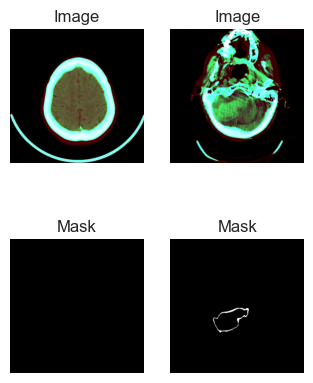

In [15]:
# Check if the dataset is working
for images, masks in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)

    # Visualize a few examples
    disp_num = 5
    plt.figure(figsize=(10, 5))
    for i in range(min(disp_num, images.shape[0])):
        plt.subplot(2, disp_num, i+1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, disp_num, i+disp_num+1)
        plt.imshow(masks[i].numpy(), cmap='gray')
        plt.title("Mask")
        plt.axis("off")
    plt.show()

In [16]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [19]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model = build_unet(input_shape)

# Compile the model
model.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model
# model.summary()

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,  # Start with fewer epochs to test
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


1180/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3943 - loss: 0.9879 - precision: 0.0107 - recall: 0.9632

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 553s 466ms/step - accuracy: 0.3945 - loss: 0.9879 - precision: 0.0107 - recall: 0.9632 - val_accuracy: 0.8347 - val_loss: 0.9862 - val_precision: 0.0352 - val_recall: 0.8923 - learning_rate: 0.0010


In [20]:
model.load_weights('best_model.h5')
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 170s 159ms/step - accuracy: 0.8422 - loss: 0.9893 - precision: 0.0298 - recall: 0.9387
Test Accuracy: 0.8431, Precision: 0.0325, Recall: 0.9285


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, dataset, num=5):
    for images, masks in dataset.take(1):  # Take one batch from dataset
        preds = model.predict(images)

        for i in range(num):
            image = images[i]
            true_mask = masks[i]
            pred_mask = preds[i]

            # Threshold predicted mask for display
            pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image.numpy())
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(true_mask), cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(pred_mask), cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()


C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(4, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


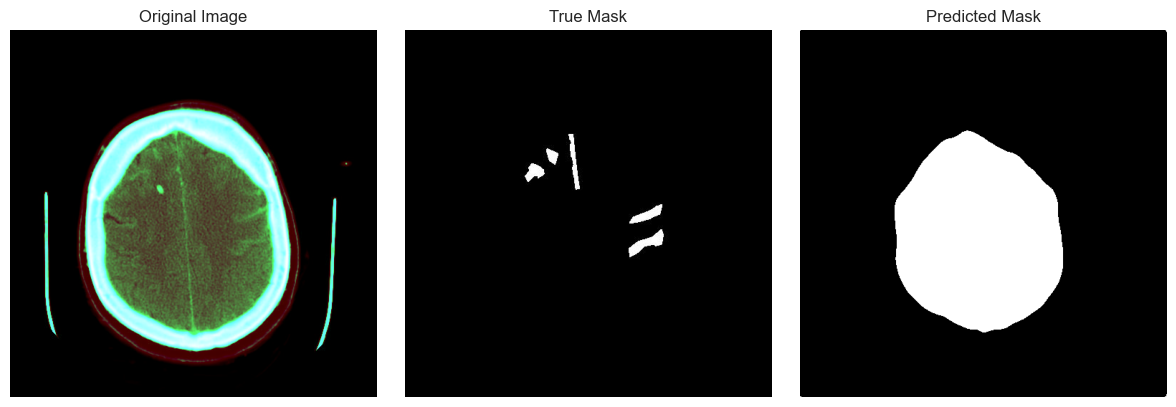

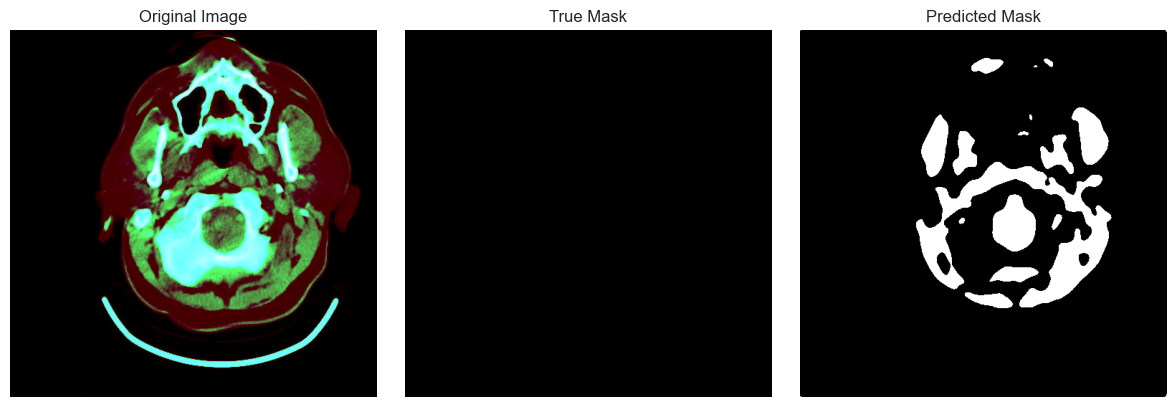

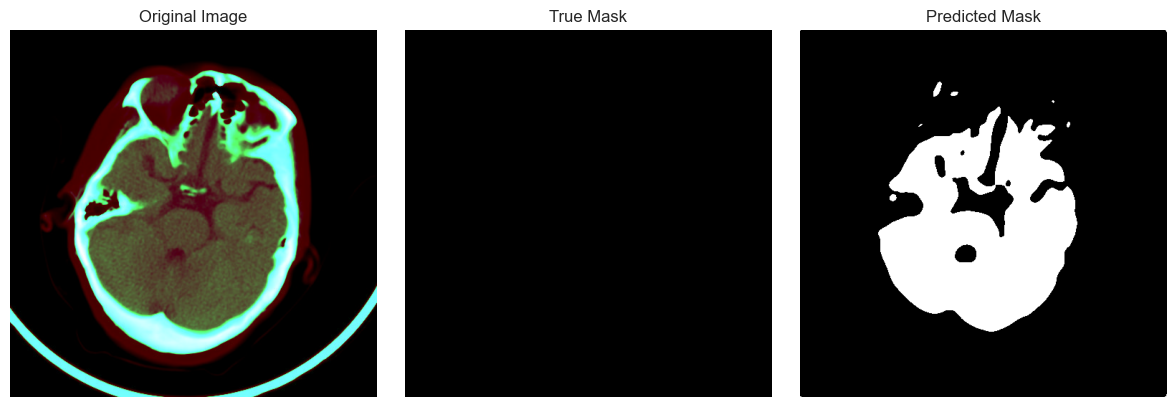

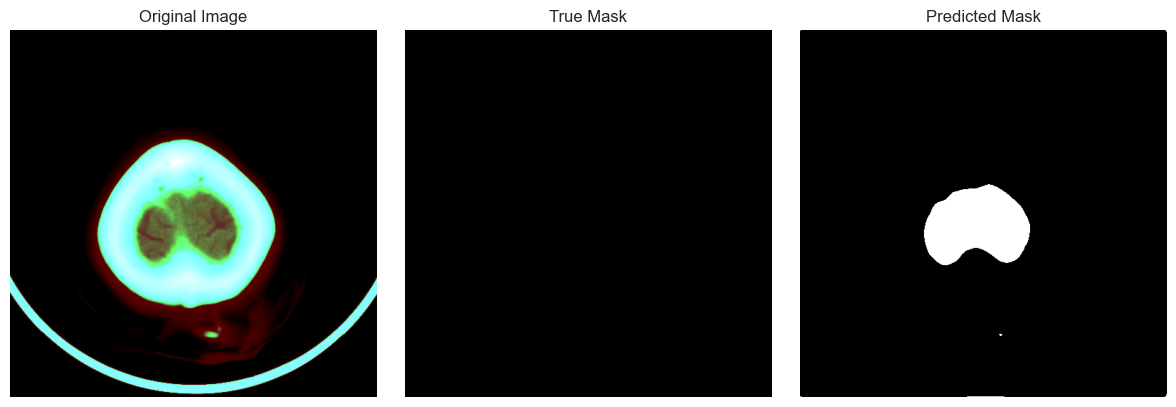

In [24]:
show_predictions(model, test_dataset, num=4)

In [17]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model2 = build_unet(input_shape)

# Compile the model2
model2.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model2
# model2.summary()

# Train the model2
history = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model2.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/15


C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5714 - loss: 0.9870 - precision: 0.0163 - recall: 0.9635

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 730s 308ms/step - accuracy: 0.5714 - loss: 0.9870 - precision: 0.0163 - recall: 0.9635 - val_accuracy: 0.8008 - val_loss: 0.9868 - val_precision: 0.0299 - val_recall: 0.9549 - learning_rate: 0.0010
Epoch 2/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 468s 198ms/step - accuracy: 0.7985 - loss: 0.9865 - precision: 0.0298 - recall: 0.9407 - val_accuracy: 0.8292 - val_loss: 0.9893 - val_precision: 0.0273 - val_recall: 0.9099 - learning_rate: 0.0010
Epoch 3/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8341 - loss: 0.9870 - precision: 0.0338 - recall: 0.9121

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 480s 203ms/step - accuracy: 0.8341 - loss: 0.9870 - precision: 0.0338 - recall: 0.9121 - val_accuracy: 0.8059 - val_loss: 0.9865 - val_precision: 0.0318 - val_recall: 0.9509 - learning_rate: 0.0010
Epoch 4/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 463s 196ms/step - accuracy: 0.8217 - loss: 0.9873 - precision: 0.0318 - recall: 0.9310 - val_accuracy: 0.8216 - val_loss: 0.9875 - val_precision: 0.0307 - val_recall: 0.9139 - learning_rate: 0.0010
Epoch 5/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 465s 197ms/step - accuracy: 0.8224 - loss: 0.9865 - precision: 0.0329 - recall: 0.9177 - val_accuracy: 0.8208 - val_loss: 0.9872 - val_precision: 0.0321 - val_recall: 0.9527 - learning_rate: 0.0010
Epoch 6/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 467s 198ms/step - accuracy: 0.8213 - loss: 0.9871 - precision: 0.0323 - recall: 0.9430 - val_accuracy: 0.8389 - val_loss: 0.9875 - val_precision: 0.0340 - val_recall: 0.9272 - learning_rate: 0.0010
Epoch 7/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 475s 201m

In [20]:
model2.load_weights('best_model2.h5')
test_loss, test_acc, test_prec, test_recall = model2.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 180s 84ms/step - accuracy: 0.8023 - loss: 0.9877 - precision: 0.0283 - recall: 0.9445
Test Accuracy: 0.8047, Precision: 0.0281, Recall: 0.9478


In [18]:
def show_predictions_dyn(model, dataset, num_batches=1,num_in_batch=5):
    for batch in range(num_batches):
        for images, masks in dataset.take(batch):
            preds = model.predict(images)

            for i in range(num_in_batch):
                image = images[i]
                true_mask = masks[i]
                pred_mask = preds[i]

                # Threshold predicted mask for display
                pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image.numpy())
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("True Mask")
                plt.imshow(tf.squeeze(true_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask), cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(2, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


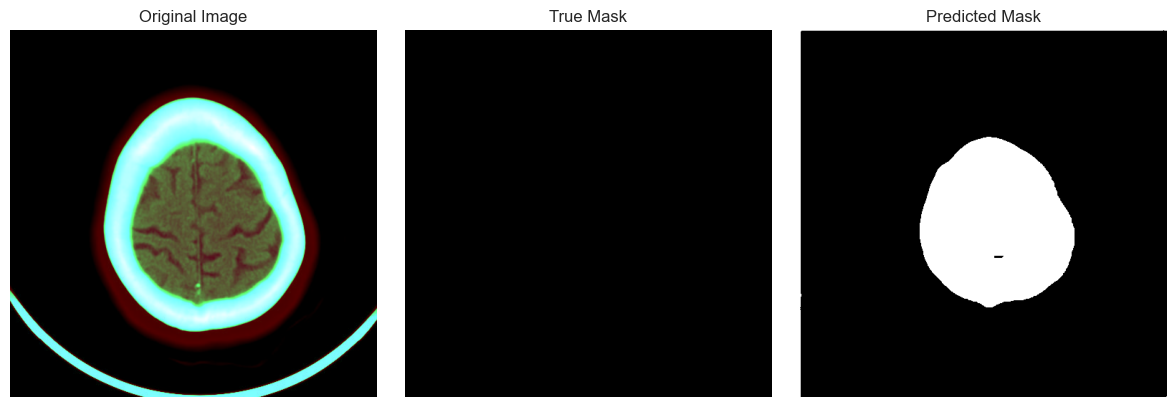

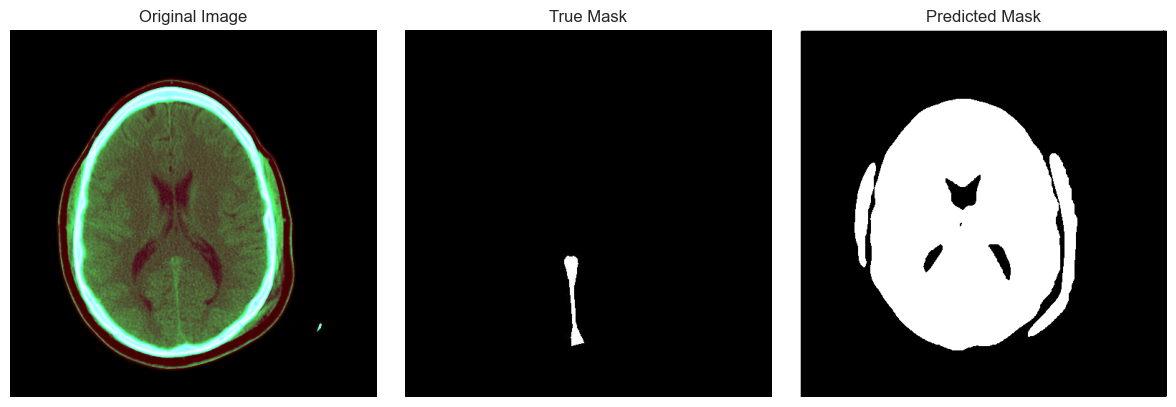

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


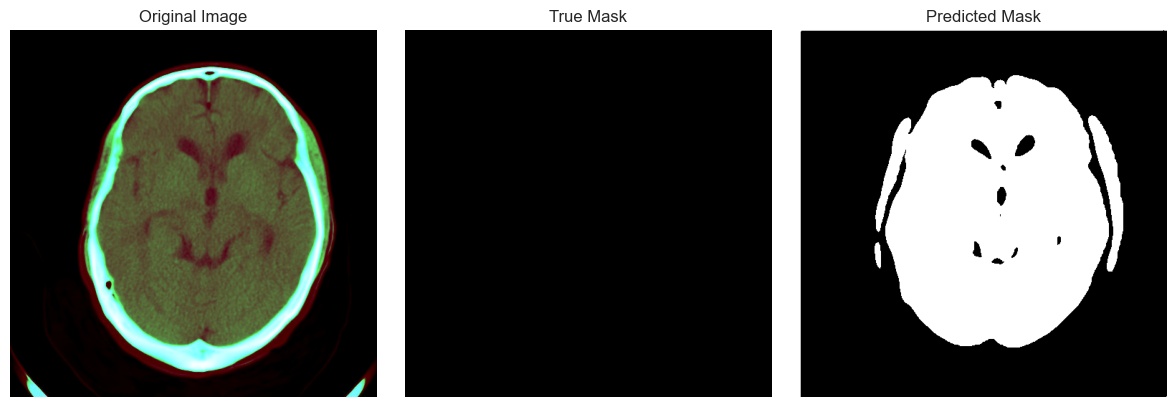

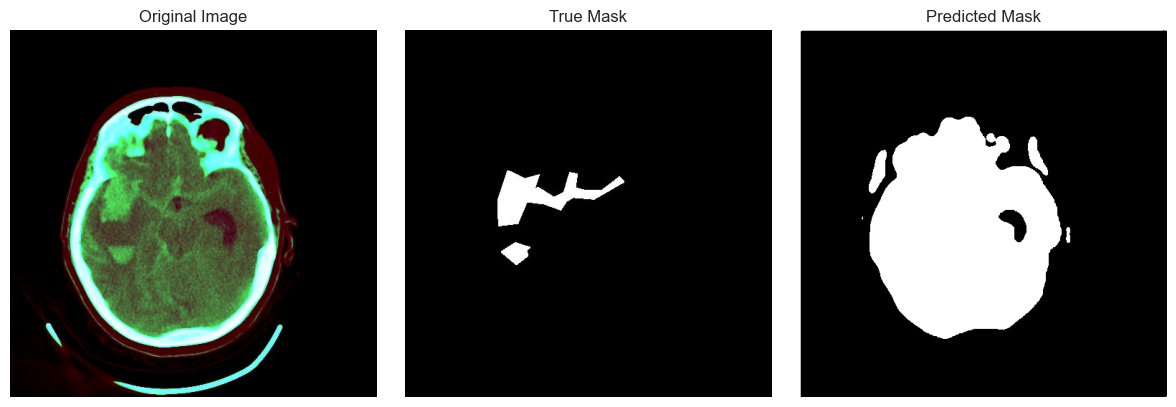

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


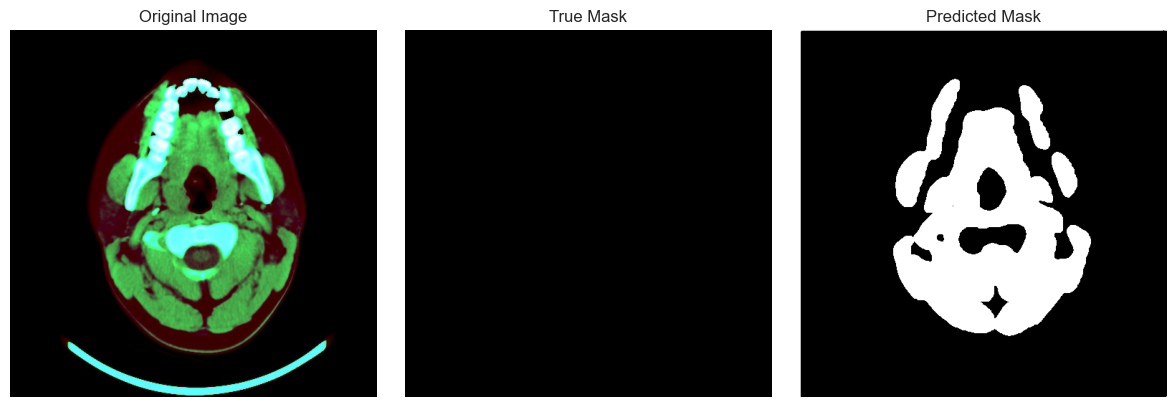

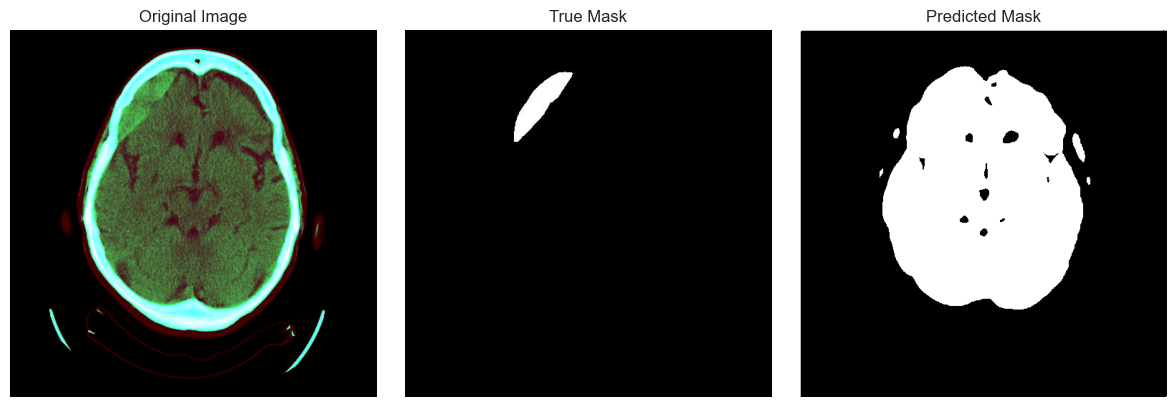

In [22]:
show_predictions_dyn(model2, test_dataset, num_batches=3,num_in_batch=2)

In [19]:
def build_medium_unet_model(input_shape):
    """
    Larger U-Net model
    """
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder
    u5 = Conv2D(64, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))
    u5 = tf.keras.layers.concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2D(32, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c5))
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c6))
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [24]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model3 = build_unet(input_shape)

# Compile the model3
model3.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model3
# model3.summary()

# Train the model3
history = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model3.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3993 - loss: 0.9873 - precision_1: 0.0099 - recall_1: 0.9236

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 496s 209ms/step - accuracy: 0.3993 - loss: 0.9873 - precision_1: 0.0099 - recall_1: 0.9236 - val_accuracy: 0.8290 - val_loss: 0.9881 - val_precision_1: 0.0306 - val_recall_1: 0.9224 - learning_rate: 0.0010
Epoch 2/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8171 - loss: 0.9874 - precision_1: 0.0301 - recall_1: 0.9173

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 476s 202ms/step - accuracy: 0.8171 - loss: 0.9874 - precision_1: 0.0301 - recall_1: 0.9173 - val_accuracy: 0.8607 - val_loss: 0.9880 - val_precision_1: 0.0359 - val_recall_1: 0.9036 - learning_rate: 0.0010
Epoch 3/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7578 - loss: 0.9865 - precision_1: 0.0242 - recall_1: 0.9019

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 468s 198ms/step - accuracy: 0.7578 - loss: 0.9865 - precision_1: 0.0242 - recall_1: 0.9019 - val_accuracy: 0.8192 - val_loss: 0.9874 - val_precision_1: 0.0304 - val_recall_1: 0.9284 - learning_rate: 0.0010
Epoch 4/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7990 - loss: 0.9871 - precision_1: 0.0277 - recall_1: 0.9058

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 462s 196ms/step - accuracy: 0.7990 - loss: 0.9871 - precision_1: 0.0277 - recall_1: 0.9058 - val_accuracy: 0.9067 - val_loss: 0.9862 - val_precision_1: 0.0587 - val_recall_1: 0.8690 - learning_rate: 0.0010
Epoch 5/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 473s 200ms/step - accuracy: 0.8592 - loss: 0.9866 - precision_1: 0.0401 - recall_1: 0.8925 - val_accuracy: 0.8089 - val_loss: 0.9880 - val_precision_1: 0.0285 - val_recall_1: 0.9575 - learning_rate: 0.0010
Epoch 6/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 467s 198ms/step - accuracy: 0.8589 - loss: 0.9871 - precision_1: 0.0381 - recall_1: 0.8591 - val_accuracy: 0.8876 - val_loss: 0.9890 - val_precision_1: 0.0410 - val_recall_1: 0.8902 - learning_rate: 0.0010
Epoch 7/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 468s 198ms/step - accuracy: 0.8284 - loss: 0.9869 - precision_1: 0.0329 - recall_1: 0.8901 - val_accuracy: 0.7903 - val_loss: 0.9866 - val_precision_1: 0.0291 - val_recall_1: 0.9658 - learning_rate: 0.0010
Epoch 8/15
2359/235

In [25]:
model3.load_weights('best_model3.h5')
test_loss, test_acc, test_prec, test_recall = model3.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 162s 82ms/step - accuracy: 0.8998 - loss: 0.9843 - precision_1: 0.0589 - recall_1: 0.7871
Test Accuracy: 0.9052, Precision: 0.0591, Recall: 0.7678


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


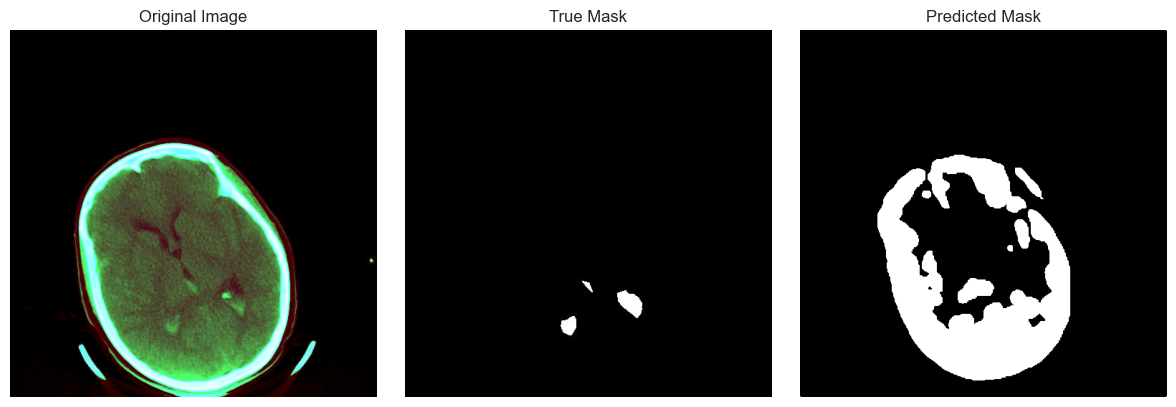

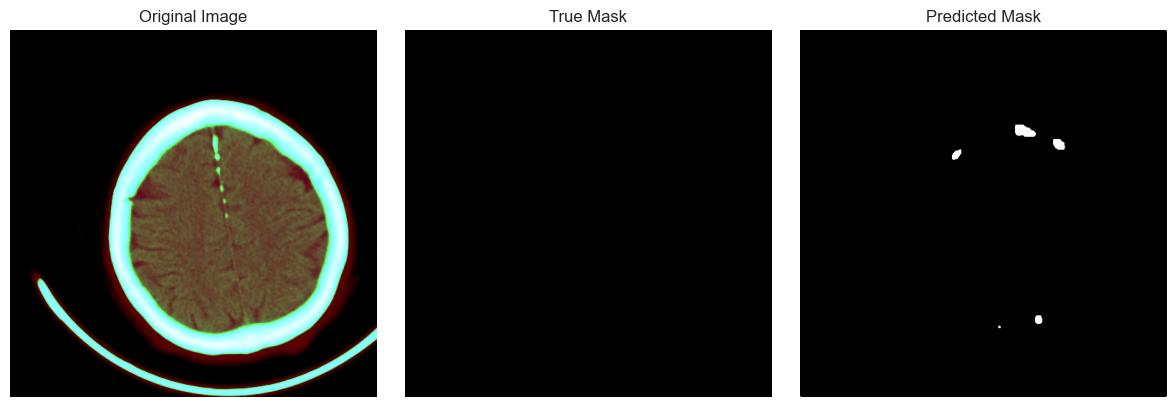

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


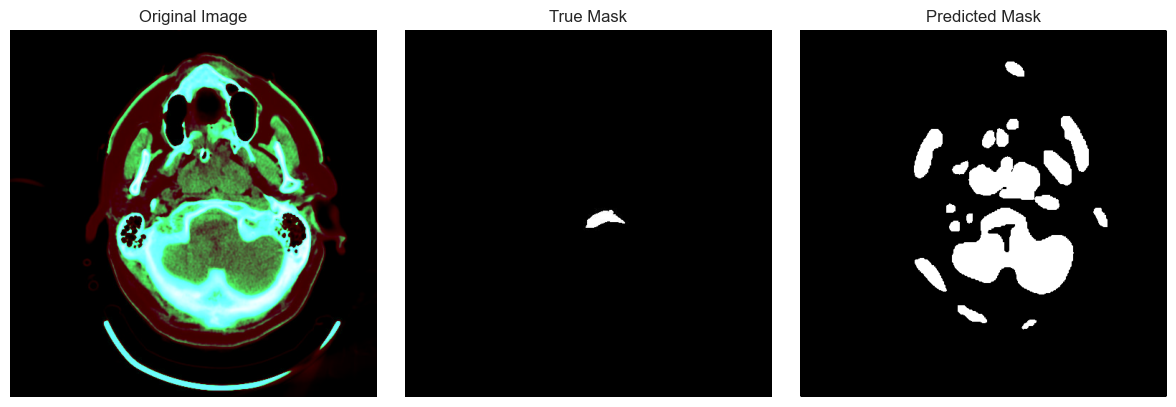

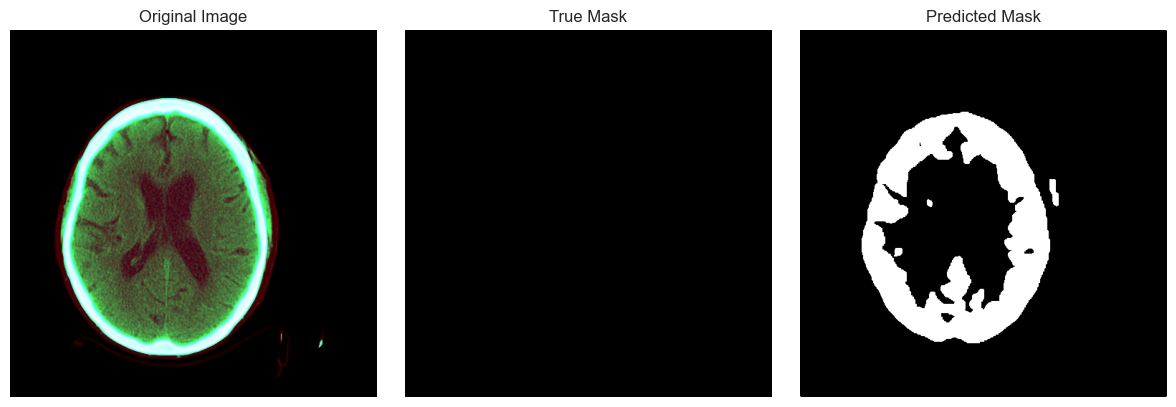

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


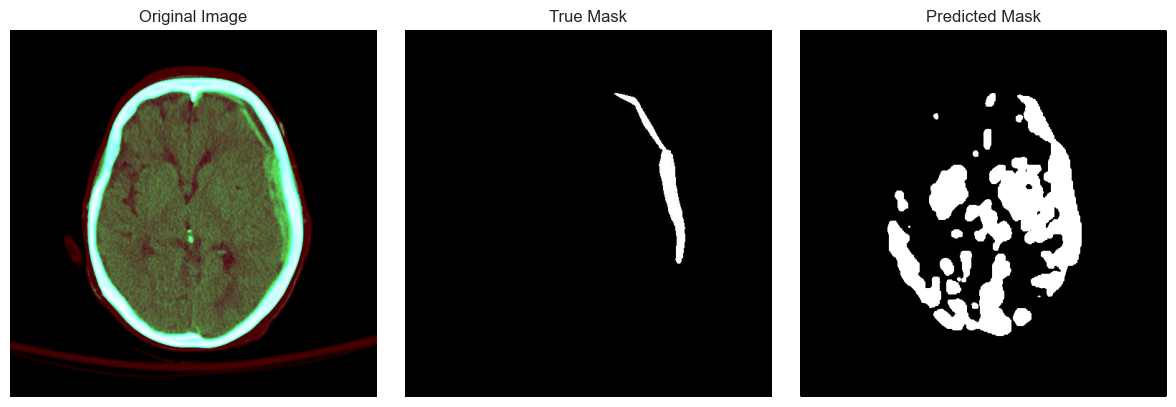

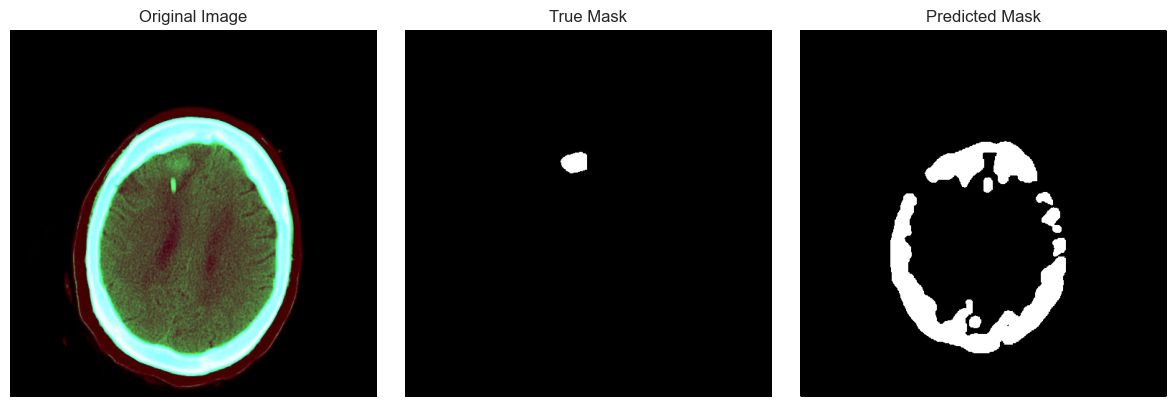

In [26]:
show_predictions_dyn(model3, test_dataset, num_batches=3,num_in_batch=2)

In [20]:
 # Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model4 = build_unet(input_shape)

# Compile the model4
model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model4
# model4.summary()

# Train the model4
history = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model4.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/15


C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9323 - loss: 0.7000 - precision: 0.0037 - recall: 0.0420

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 514s 216ms/step - accuracy: 0.9324 - loss: 0.7000 - precision: 0.0037 - recall: 0.0420 - val_accuracy: 0.9940 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 628s 266ms/step - accuracy: 0.9932 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9945 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 485s 206ms/step - accuracy: 0.9938 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9937 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 487s 206ms/step - accuracy: 0.9938 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9940 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.

In [21]:
model4.load_weights('best_model4.h5')
test_loss, test_acc, test_prec, test_recall = model4.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 170s 81ms/step - accuracy: 0.9937 - loss: 0.6931 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Accuracy: 0.9941, Precision: 0.0000, Recall: 0.0000


C:\Users\brode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image_input']
Received: inputs=Tensor(shape=(2, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


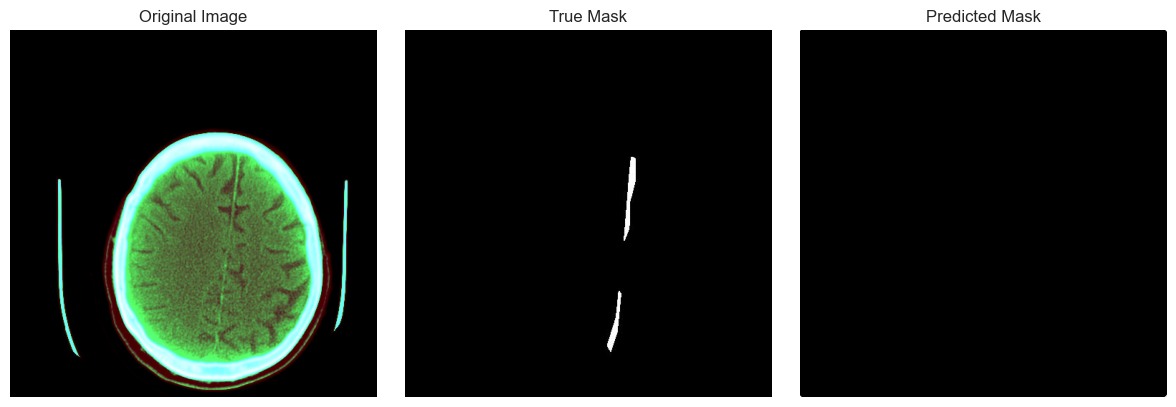

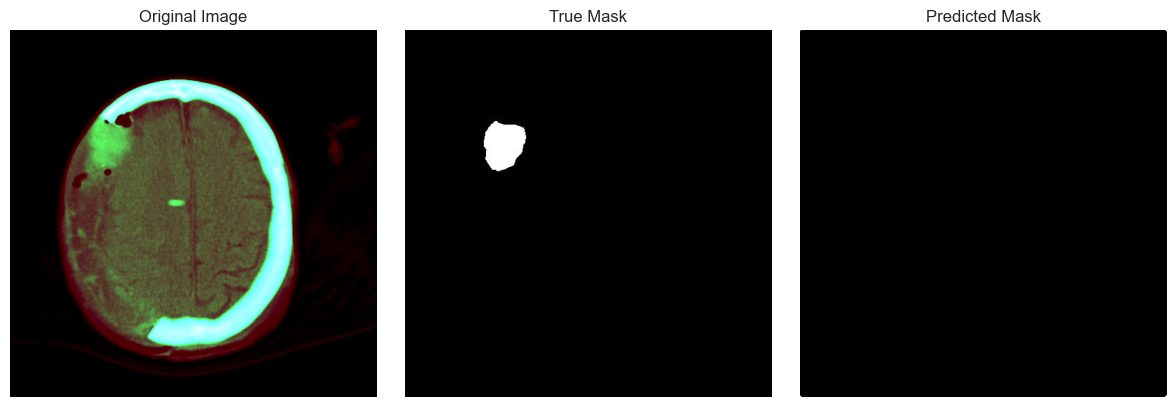

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


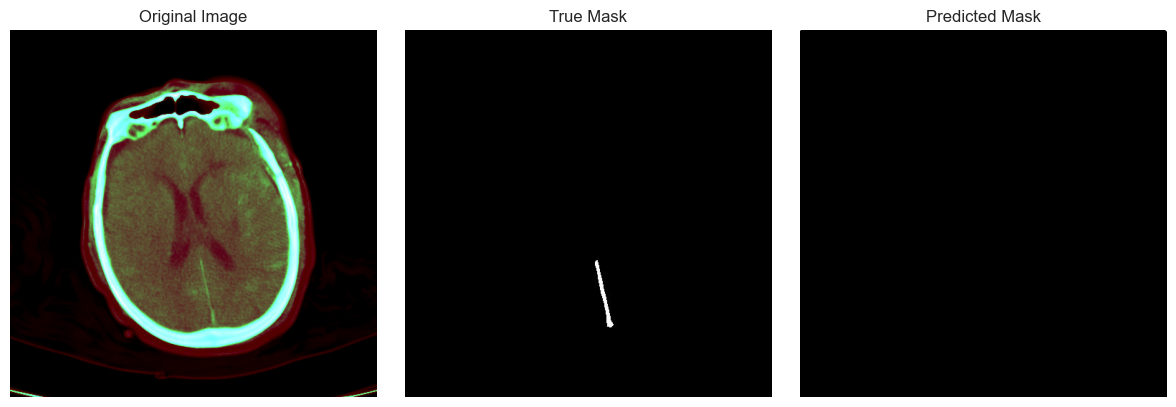

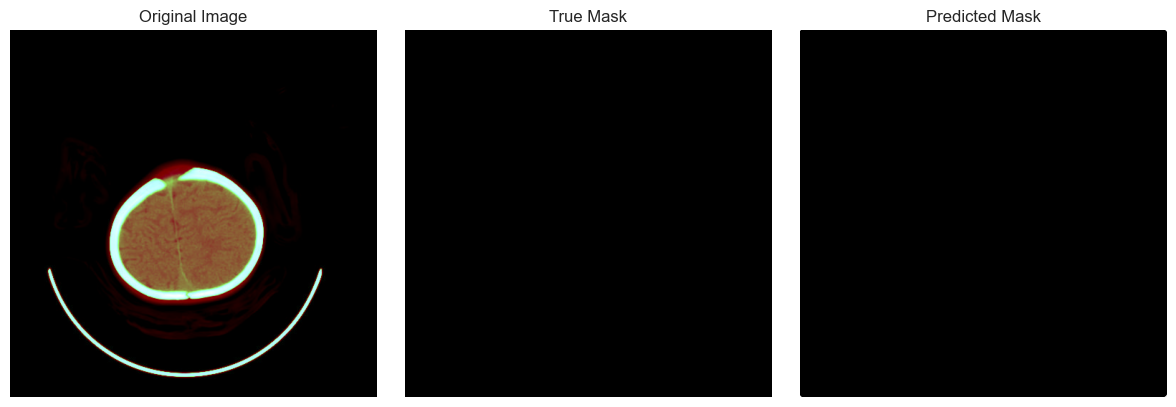

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


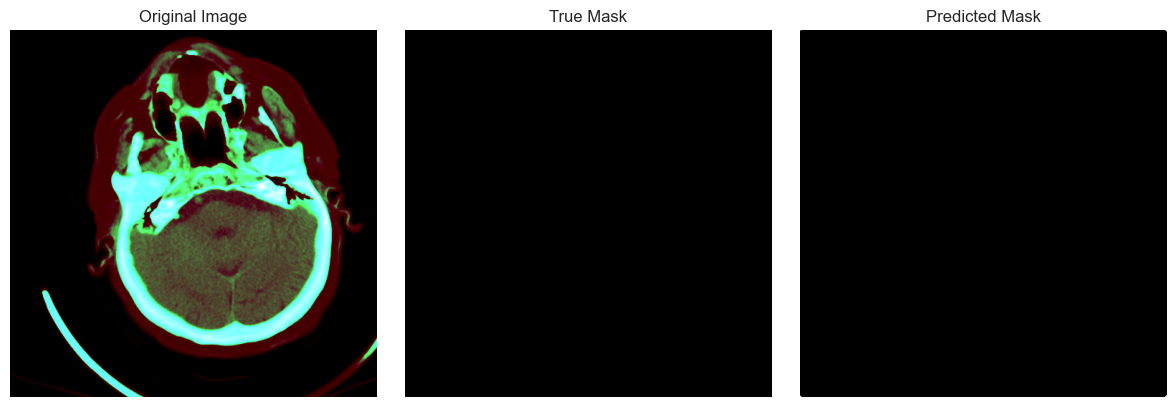

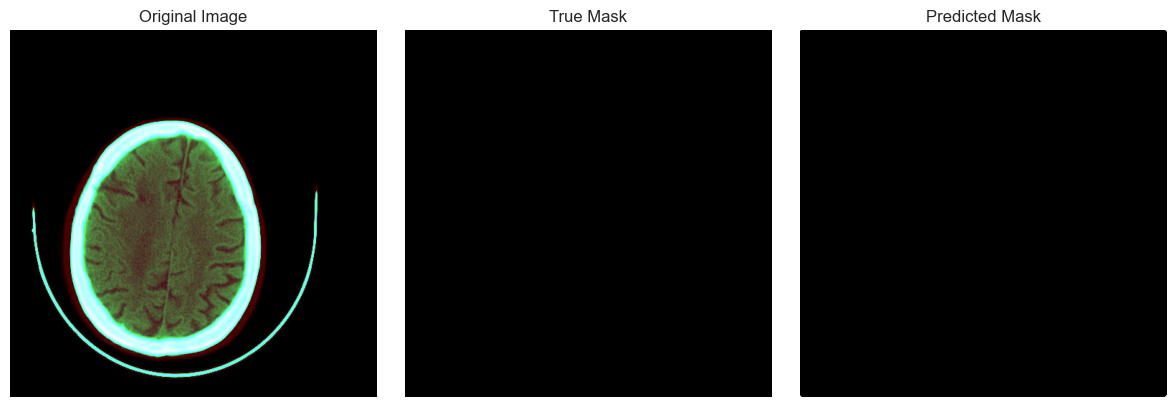

In [22]:
show_predictions_dyn(model4, test_dataset, num_batches=3, num_in_batch=2)

In [23]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

In [24]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model5 = build_medium_unet_model(input_shape)

# Compile the model5
model5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model5
# model5.summary()

# Train the model5
history = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model5.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9724 - loss: 0.6974 - precision_1: 0.0050 - recall_1: 0.0153

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 2000s 845ms/step - accuracy: 0.9724 - loss: 0.6974 - precision_1: 0.0050 - recall_1: 0.0153 - val_accuracy: 0.9948 - val_loss: 0.6931 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 2003s 849ms/step - accuracy: 0.9936 - loss: 0.6932 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9935 - val_loss: 0.6931 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 2054s 870ms/step - accuracy: 0.9936 - loss: 0.6932 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9938 - val_loss: 0.6931 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 2058s 872ms/step - accuracy: 0.9938 - loss: 0.6932 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9943 - val_loss: 0.6931 - val_precision_1: 0.0000e+00 - val_reca

In [25]:
model5.load_weights('best_model5.h5')
test_loss, test_acc, test_prec, test_recall = model5.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 198s 196ms/step - accuracy: 0.9948 - loss: 0.6931 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test Accuracy: 0.9946, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


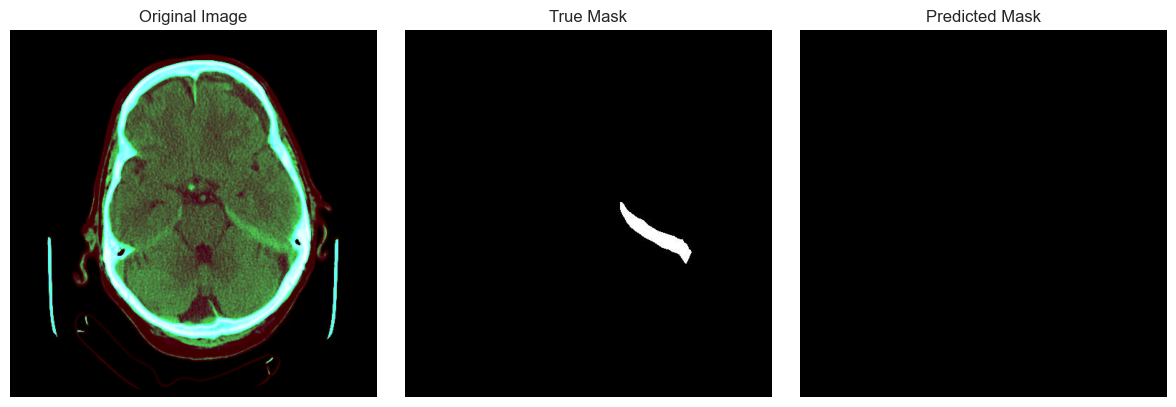

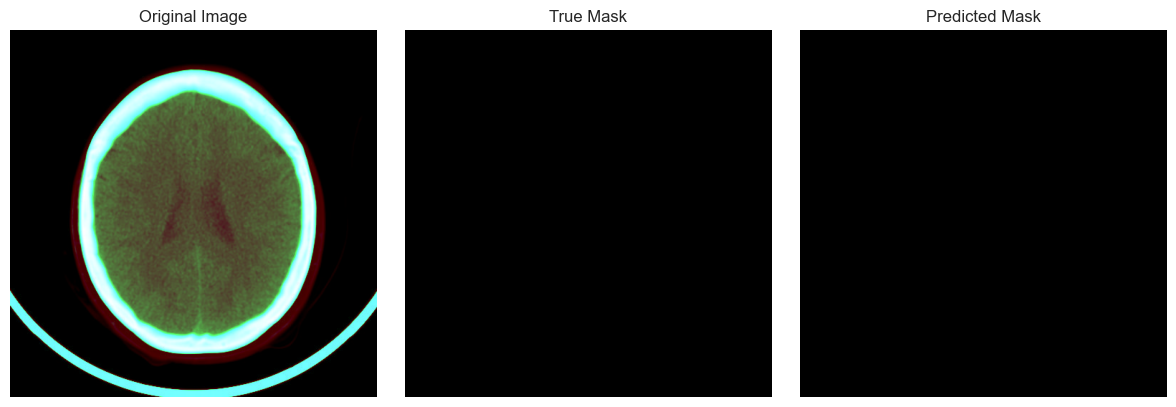

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


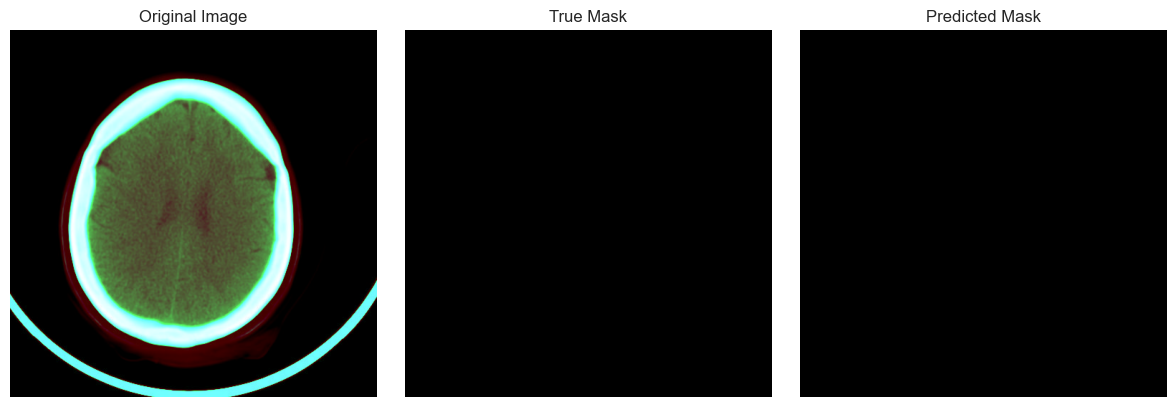

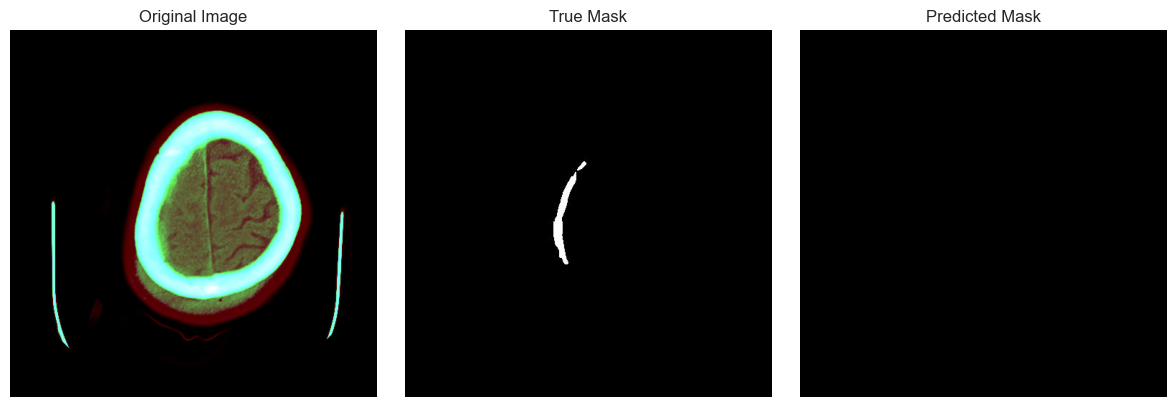

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


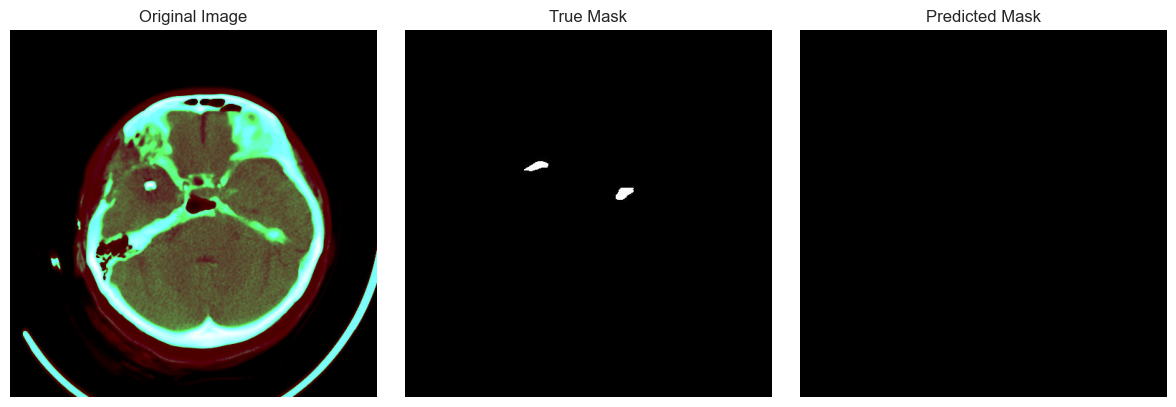

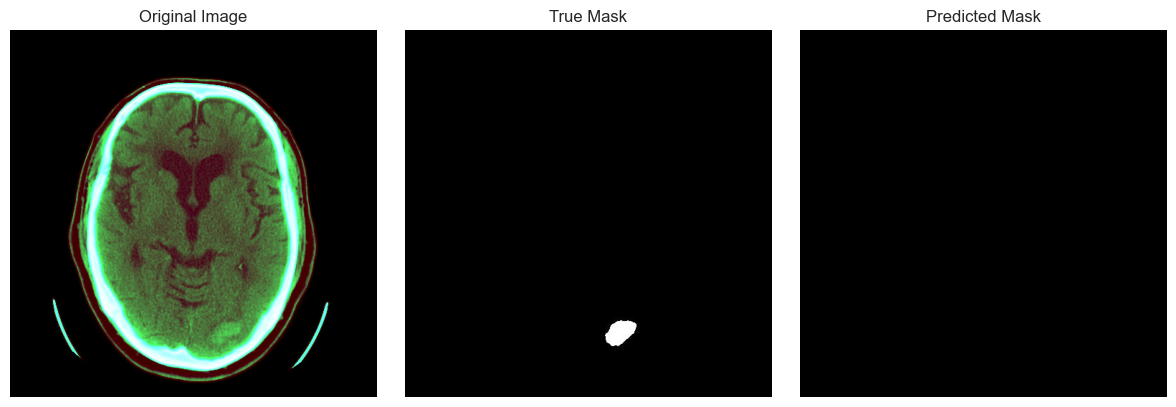

In [26]:
show_predictions_dyn(model5, test_dataset, num_batches=3, num_in_batch=2)

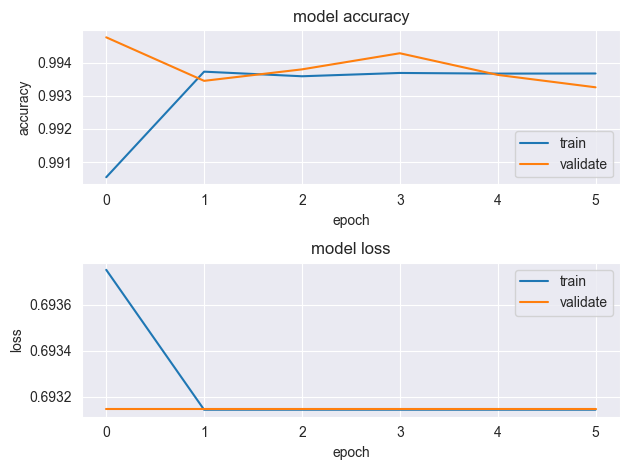

In [28]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [33]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model6 = build_medium_unet_model(input_shape)

# Compile the model6
model6.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model6
# model6.summary()

# Train the model6
history = model6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model6.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

In [34]:
model6.load_weights('best_model6.h5')
test_loss, test_acc, test_prec, test_recall = model6.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 200s 190ms/step - accuracy: 0.9939 - loss: 1.6835 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Test Accuracy: 0.9942, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


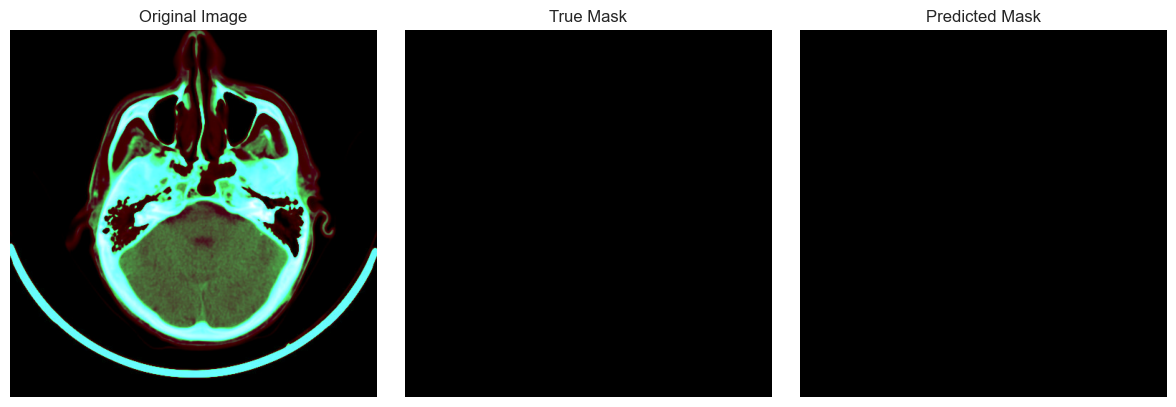

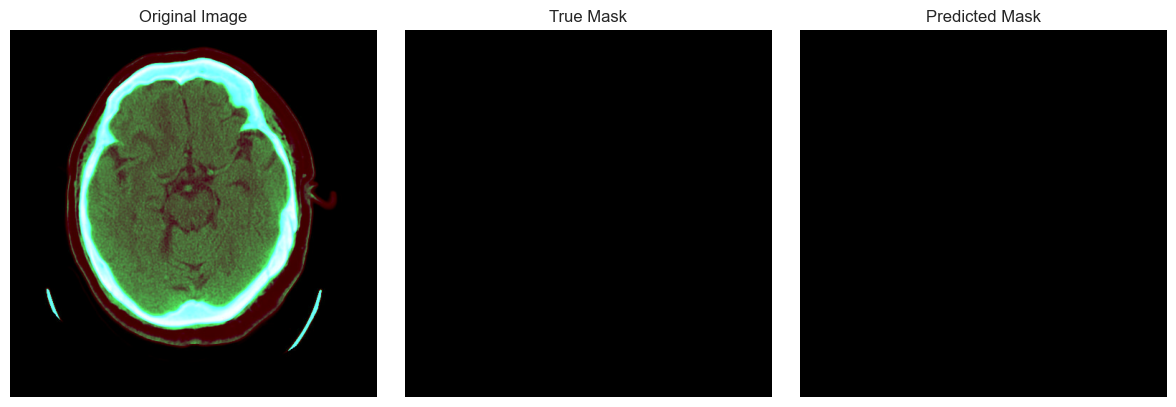

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


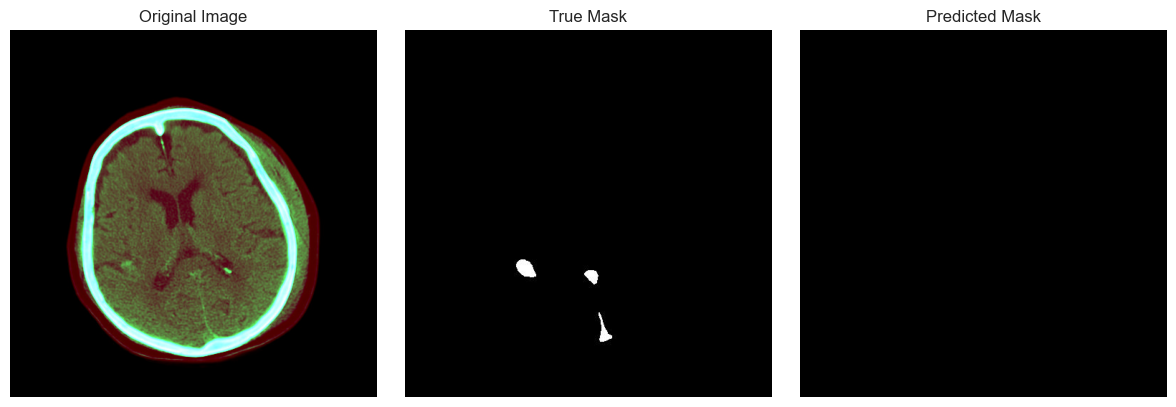

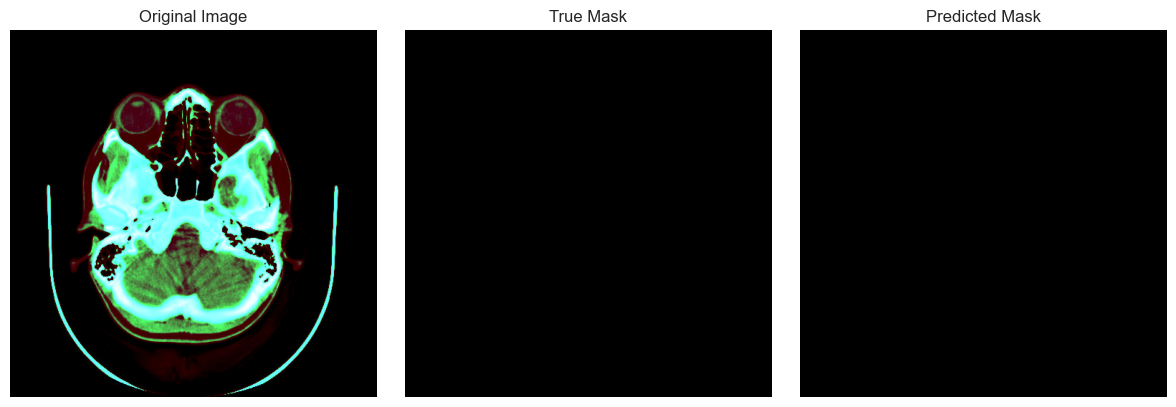

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


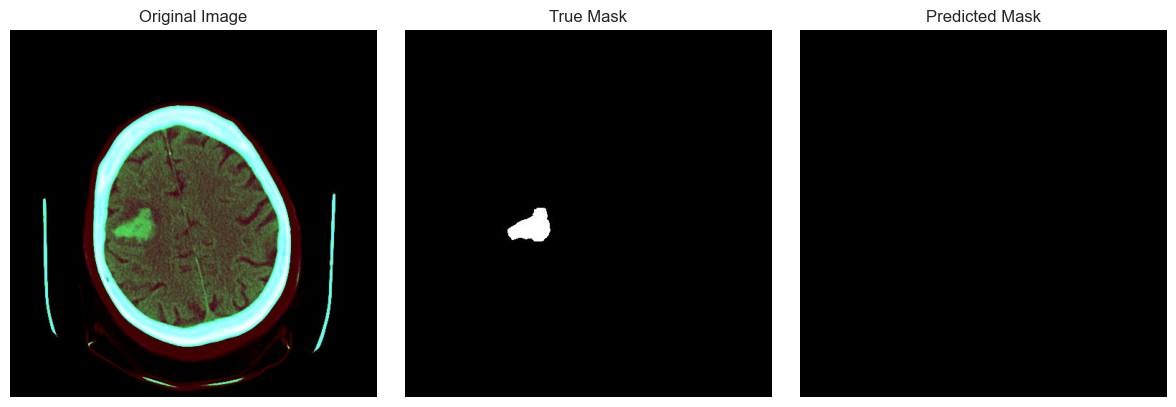

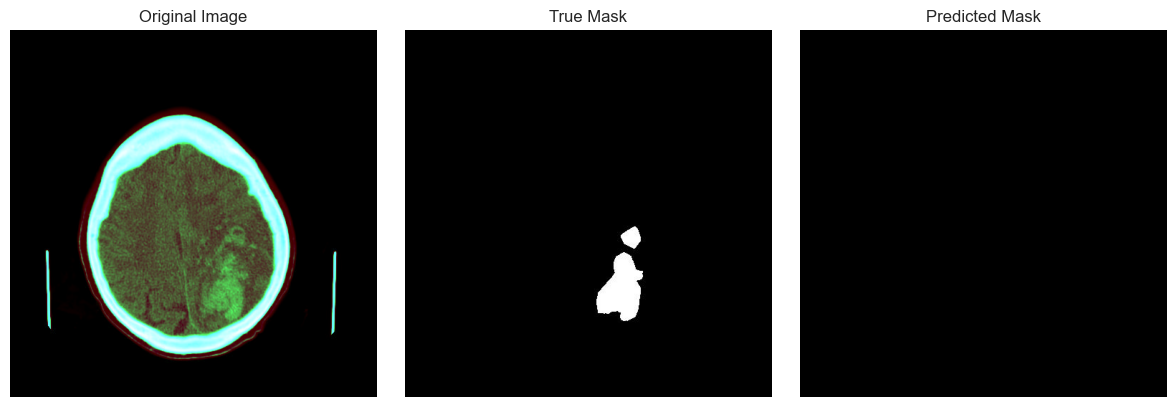

In [35]:
show_predictions_dyn(model6, test_dataset, num_batches=3, num_in_batch=2)

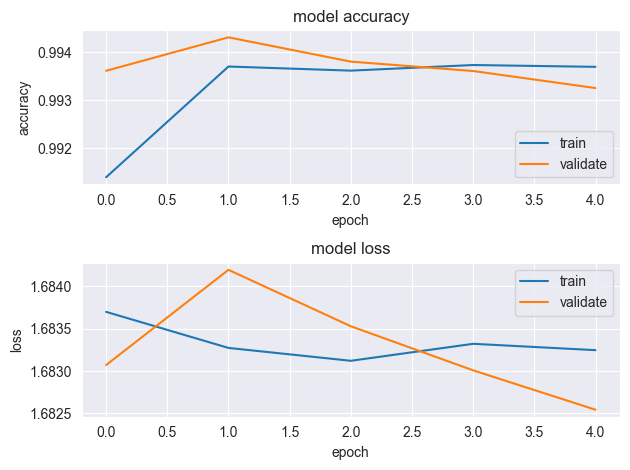

In [36]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()